In [1]:
import struct
import numpy as np
import matplotlib.pyplot as plt

from MyFunc import *
from MyNet import *

In [2]:
def image_data(file_name):
    with open(file_name, 'rb') as f:
        buffer = f.read(16)
        magic, num, rows, cols = struct.unpack('>iiii', buffer)
        buffer = f.read(rows * cols * num)
        data = np.frombuffer(buffer, dtype=np.uint8)
        data = data.reshape(num, rows, cols)
    return data

def label_data(file_name):
    with open(file_name, 'rb') as f:
        buffer = f.read(8)
        magic, num = struct.unpack('>ii', buffer)
        buffer = f.read(num)
        data = np.frombuffer(buffer, dtype=np.uint8)
        data = data.reshape(num, 1)
    return data

(60000, 28, 28) (60000, 1)


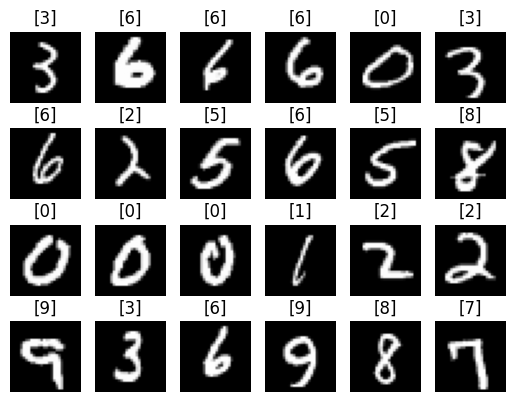

In [3]:
# 读取文件数据
images = image_data("data/train-images.idx3-ubyte")
labels = label_data("data/train-labels.idx1-ubyte")
print(images.shape, labels.shape)

# 随机打乱数据
np.random.seed(0)
indices = np.random.permutation(len(images))
images = images[indices]
labels = labels[indices]

for i in range(24):
    plt.subplot(4, 6, i + 1)
    plt.imshow(images[i], cmap="gray")
    plt.title(labels[i])
    plt.axis("off")
plt.show()

In [4]:
# 分割训练集与验证集 (4:1)
split = int(len(images) * 0.8)
train_images, valid_images = images[:split], images[split:]
train_labels, valid_labels = labels[:split], labels[split:]

In [5]:
def one_hot(labels, num_classes):
    one_hot_labels = np.zeros((len(labels), num_classes))
    for i in range(len(labels)):
        one_hot_labels[i, labels[i]] = 1
    return one_hot_labels

In [6]:
# 添加图片通道
height, width = images.shape[1], images.shape[2]
train_images = train_images.reshape(train_images.shape[0], 1, height, width)
valid_images = valid_images.reshape(valid_images.shape[0], 1, height, width)

# 独热标签数据
train_labels = one_hot(train_labels, 10)
valid_labels = one_hot(valid_labels, 10)

print(train_images.shape, valid_images.shape)
print(train_labels.shape, valid_labels.shape)

(48000, 1, 28, 28) (12000, 1, 28, 28)
(48000, 10) (12000, 10)


In [7]:
def shuffle_data(images, labels):
    np.random.seed(0)
    indices = np.random.permutation(len(images))
    return images[indices], labels[indices]

In [8]:
# net_info = [
#     # (batch_size, 1, 28, 28) -> (batch_size, 2, 24, 24)
#     {"module": Conv2d, "param": {"in_channels": 1, "out_channels": 2, "kernel_size": 5}},
#     # (batch_size, 2, 24, 24)
#     {"module": Flatten},
#     {"module": Mlp, "param": {"in_features": 1152, "out_features": 64}},
#     {"module": Gelu},
#     {"module": Dropout, "param": {"p": 0.2}},
#     {"module": Mlp, "param": {"in_features": 64, "out_features": 10}},
#     {"module": Softmax},
# ]

net_info = [
    {"module": Flatten},
    {"module": Mlp, "param": {"in_features": 784, "out_features": 256}},
    {"module": Gelu},
    {"module": Dropout, "param": {"p": 0.2}},
    {"module": Mlp, "param": {"in_features": 256, "out_features": 64}},
    {"module": Gelu},
    {"module": Dropout, "param": {"p": 0.2}},
    {"module": Mlp, "param": {"in_features": 64, "out_features": 16}},
    {"module": Gelu},
    {"module": Dropout, "param": {"p": 0.2}},
    {"module": Mlp, "param": {"in_features": 16, "out_features": 10}},
    {"module": Softmax},
]

net = Net(net_info, 2)

In [9]:
# 保存模型
# net.save("model/img_net.pkl")

In [10]:
# 加载模型
# net.load("model/img_net.pkl")

In [20]:
epochs = 5
for i in range(epochs):
    train_images, train_labels = shuffle_data(train_images, train_labels)
    net.train(train_images, train_labels, CrossEntropy, 500, 1)

    _train_labels = net.pred(train_images)
    _valid_labels = net.pred(valid_images)
    _train_loss = CrossEntropy.forward(train_labels, _train_labels) * 100
    _valid_loss = CrossEntropy.forward(valid_labels, _valid_labels) * 100

    _valid_accuracy = np.mean(np.argmax(_valid_labels, axis=1) == np.argmax(valid_labels, axis=1)) * 100
    print(f"Epoch: {i}, Train Loss: {_train_loss:.4f}, Valid Loss: {_valid_loss:.4f}, Valid Accuracy: {_valid_accuracy:.2f}%")

net.save("model/img_net.pkl")

Epoch: 0, Train Loss: 2.2262, Valid Loss: 8.9937, Valid Accuracy: 97.87%
Epoch: 1, Train Loss: 2.2142, Valid Loss: 9.0009, Valid Accuracy: 97.79%
Epoch: 2, Train Loss: 2.2098, Valid Loss: 8.9256, Valid Accuracy: 97.86%
Epoch: 3, Train Loss: 2.2083, Valid Loss: 8.9263, Valid Accuracy: 97.86%
Epoch: 4, Train Loss: 2.2027, Valid Loss: 8.9487, Valid Accuracy: 97.89%


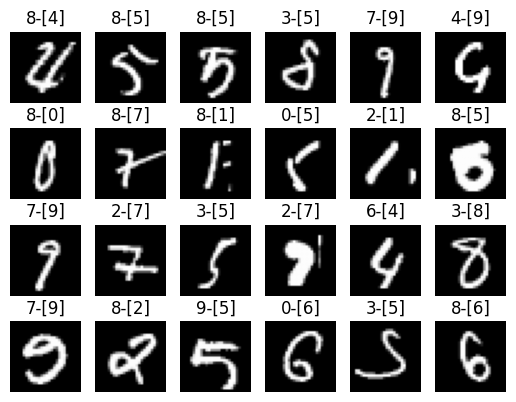

In [21]:
# 打印识别失败的图片
_valid_labels = net.pred(valid_images)
indices = np.argmax(_valid_labels, axis=1) != np.argmax(valid_labels, axis=1)
indices = np.random.permutation(np.where(indices)[0])


# 标题为 (预测-准确)
for i in range(24):
    plt.subplot(4, 6, i + 1)
    plt.imshow(valid_images[indices][i].reshape(28, 28), cmap="gray")
    plt.title(f"{np.argmax(_valid_labels[indices][i])}-[{np.argmax(valid_labels[indices][i])}]")
    plt.axis("off")
plt.show()